In [1]:
!rm -rf ./TA_session
!git clone https://github.com/intelpro/TA_session
!ls ./TA_session/EFNet/
!pip install einops

Cloning into 'TA_session'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 384 (delta 12), reused 26 (delta 5), pack-reused 347
Receiving objects: 100% (384/384), 45.52 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (177/177), done.
ckpts  EFNet.ipynb  image.png  samples
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 886.5 kB/s eta 0:00:00


# import로 모듈 가져오기
torch에 있는 module, 우리가 사전에 정의해놓았던 함수 등 import로 가져온다.

In [2]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from einops import rearrange
import numbers

### Event-Image fusion module 정의를 위해서 여러가지 함수들을 import 합니다.

#### batch의 dimension을 rearrange 하는 함수

In [3]:
def to_3d(x):
    return rearrange(x, 'b c h w -> b (h w) c')

def to_4d(x,h,w):
    return rearrange(x, 'b (h w) c -> b c h w',h=h,w=w)

#### Layer normalization 함수

In [4]:
class BiasFree_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(BiasFree_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return x / torch.sqrt(sigma+1e-5) * self.weight

class WithBias_LayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(WithBias_LayerNorm, self).__init__()
        if isinstance(normalized_shape, numbers.Integral):
            normalized_shape = (normalized_shape,)
        normalized_shape = torch.Size(normalized_shape)

        assert len(normalized_shape) == 1

        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.normalized_shape = normalized_shape

    def forward(self, x):
        mu = x.mean(-1, keepdim=True)
        sigma = x.var(-1, keepdim=True, unbiased=False)
        return (x - mu) / torch.sqrt(sigma+1e-5) * self.weight + self.bias


class LayerNorm(nn.Module):
    def __init__(self, dim, LayerNorm_type):
        super(LayerNorm, self).__init__()
        if LayerNorm_type =='BiasFree':
            self.body = BiasFree_LayerNorm(dim)
        else:
            self.body = WithBias_LayerNorm(dim)

    def forward(self, x):
        h, w = x.shape[-2:]
        return to_4d(self.body(to_3d(x)), h, w)

#### Event-Image fusion module 정의

In [5]:
class Mutual_Attention(nn.Module):
    def __init__(self, dim, num_heads, bias):
        super(Mutual_Attention, self).__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))
        self.q = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        self.k = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        self.v = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=bias)


    def forward(self, x, y):

        assert x.shape == y.shape, 'The shape of feature maps from image and event branch are not equal!'

        b,c,h,w = x.shape

        q = self.q(x) # image
        k = self.k(y) # event
        v = self.v(y) # event

        q = rearrange(q, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        k = rearrange(k, 'b (head c) h w -> b head c (h w)', head=self.num_heads)
        v = rearrange(v, 'b (head c) h w -> b head c (h w)', head=self.num_heads)

        q = torch.nn.functional.normalize(q, dim=-1)
        k = torch.nn.functional.normalize(k, dim=-1)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)
        out = (attn @ v)
        out = rearrange(out, 'b head c (h w) -> b (head c) h w', head=self.num_heads, h=h, w=w)
        out = self.project_out(out)
        return out

In [6]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [7]:
##########################################################################
## Event-Image Channel Attention (EICA)
class EventImage_ChannelAttentionTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_expansion_factor=2, bias=False, LayerNorm_type='WithBias'):
        super(EventImage_ChannelAttentionTransformerBlock, self).__init__()

        self.norm1_image = LayerNorm(dim, LayerNorm_type)
        self.norm1_event = LayerNorm(dim, LayerNorm_type)
        self.attn = Mutual_Attention(dim, num_heads, bias)
        # mlp
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * ffn_expansion_factor)
        self.ffn = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU, drop=0.)

    def forward(self, image, event):
        # image: b, c, h, w
        # event: b, c, h, w
        # return: b, c, h, w
        assert image.shape == event.shape, 'the shape of image doesnt equal to event'
        b, c , h, w = image.shape
        fused = image + self.attn(self.norm1_image(image), self.norm1_event(event)) # b, c, h, w

        # mlp
        fused = to_3d(fused) # b, h*w, c
        fused = fused + self.ffn(self.norm2(fused))
        fused = to_4d(fused, h, w)
        return fused

#### Define conv layers

In [8]:
def conv3x3(in_chn, out_chn, bias=True):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=3, stride=1, padding=1, bias=bias)
    return layer

def conv_down(in_chn, out_chn, bias=False):
    layer = nn.Conv2d(in_chn, out_chn, kernel_size=4, stride=2, padding=1, bias=bias)
    return layer

def conv(in_channels, out_channels, kernel_size, bias=False, stride = 1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias, stride = stride)

In [9]:
class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample, relu_slope, use_emgc=False, num_heads=None): # cat
        super(UNetConvBlock, self).__init__()
        self.downsample = downsample
        self.identity = nn.Conv2d(in_size, out_size, 1, 1, 0)
        self.use_emgc = use_emgc
        self.num_heads = num_heads

        self.conv_1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_1 = nn.LeakyReLU(relu_slope, inplace=False)
        self.conv_2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_2 = nn.LeakyReLU(relu_slope, inplace=False)

        if downsample and use_emgc:
            self.emgc_enc = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_dec = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_enc_mask = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_dec_mask = nn.Conv2d(out_size, out_size, 3, 1, 1)

        if downsample:
            self.downsample = conv_down(out_size, out_size, bias=False)

        if self.num_heads is not None:
            self.image_event_transformer = EventImage_ChannelAttentionTransformerBlock(out_size, num_heads=self.num_heads, ffn_expansion_factor=4, bias=False, LayerNorm_type='WithBias')


    def forward(self, x, enc=None, dec=None, mask=None, event_filter=None, merge_before_downsample=True):
        out = self.conv_1(x)

        out_conv1 = self.relu_1(out)
        out_conv2 = self.relu_2(self.conv_2(out_conv1))

        out = out_conv2 + self.identity(x)

        if enc is not None and dec is not None and mask is not None:
            assert self.use_emgc
            out_enc = self.emgc_enc(enc) + self.emgc_enc_mask((1-mask)*enc)
            out_dec = self.emgc_dec(dec) + self.emgc_dec_mask(mask*dec)
            out = out + out_enc + out_dec

        if event_filter is not None and merge_before_downsample:
            # b, c, h, w = out.shape
            out = self.image_event_transformer(out, event_filter)

        if self.downsample:
            out_down = self.downsample(out)
            if not merge_before_downsample:
                out_down = self.image_event_transformer(out_down, event_filter)

            return out_down, out

        else:
            if merge_before_downsample:
                return out
            else:
                out = self.image_event_transformer(out, event_filter)

In [10]:
class UNetEVConvBlock(nn.Module):
    def __init__(self, in_size, out_size, downsample, relu_slope, use_emgc=False):
        super(UNetEVConvBlock, self).__init__()
        self.downsample = downsample
        self.identity = nn.Conv2d(in_size, out_size, 1, 1, 0)
        self.use_emgc = use_emgc
        self.conv_1 = nn.Conv2d(in_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_1 = nn.LeakyReLU(relu_slope, inplace=False)
        self.conv_2 = nn.Conv2d(out_size, out_size, kernel_size=3, padding=1, bias=True)
        self.relu_2 = nn.LeakyReLU(relu_slope, inplace=False)

        self.conv_before_merge = nn.Conv2d(out_size, out_size , 1, 1, 0)
        if downsample and use_emgc:
            self.emgc_enc = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_dec = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_enc_mask = nn.Conv2d(out_size, out_size, 3, 1, 1)
            self.emgc_dec_mask = nn.Conv2d(out_size, out_size, 3, 1, 1)

        if downsample:
            self.downsample = conv_down(out_size, out_size, bias=False)

    def forward(self, x, merge_before_downsample=True):
        out = self.conv_1(x)
        out_conv1 = self.relu_1(out)
        out_conv2 = self.relu_2(self.conv_2(out_conv1))
        out = out_conv2 + self.identity(x)

        if self.downsample:
            out_down = self.downsample(out)
            if not merge_before_downsample:

                out_down = self.conv_before_merge(out_down)
            else :
                out = self.conv_before_merge(out)
            return out_down, out
        else:

            out = self.conv_before_merge(out)
            return out


In [11]:
class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, relu_slope):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2, bias=True)
        self.conv_block = UNetConvBlock(in_size, out_size, False, relu_slope)

    def forward(self, x, bridge):
        up = self.up(x)
        out = torch.cat([up, bridge], 1)
        out = self.conv_block(out)
        return out

### Define EF-Net

### [LAB]SAM(Supervised attention module)

![alt text](./image.png)

In [12]:
## Supervised Attention Module
## https://github.com/swz30/MPRNet
class SAM(nn.Module):
    def __init__(self, n_feat, kernel_size=3, bias=True):
        super(SAM, self).__init__()
        self.conv1 = conv(n_feat, n_feat, kernel_size, bias=bias)
        self.conv2 = conv(n_feat, 3, kernel_size, bias=bias)
        self.conv3 = conv(3, n_feat, kernel_size, bias=bias)

    def forward(self, x, x_img):
        # x1 = NotImplemented
        # img = NotImplemented
        x1 = self.conv1(x)
        img = self.conv2(x) + x_img
        # x2 = torch.sigmoid(self.conv3(img))
        x2 = F.sigmoid(self.conv3(img))
        x1 = x1*x2
        x1 = x1+x
        return x1, img

In [13]:
class EFNet(nn.Module):
    def __init__(self, in_chn=3, ev_chn=6, wf=64, depth=3, fuse_before_downsample=True, relu_slope=0.2, num_heads=[1,2,4]):
        super(EFNet, self).__init__()
        self.depth = depth
        self.fuse_before_downsample = fuse_before_downsample
        self.num_heads = num_heads
        self.down_path_1 = nn.ModuleList()
        self.down_path_2 = nn.ModuleList()
        self.conv_01 = nn.Conv2d(in_chn, wf, 3, 1, 1)
        self.conv_02 = nn.Conv2d(in_chn, wf, 3, 1, 1)
        # event
        self.down_path_ev = nn.ModuleList()
        self.conv_ev1 = nn.Conv2d(ev_chn, wf, 3, 1, 1)
        prev_channels = self.get_input_chn(wf)
        for i in range(depth):
            downsample = True if (i+1) < depth else False

            self.down_path_1.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, num_heads=self.num_heads[i]))
            self.down_path_2.append(UNetConvBlock(prev_channels, (2**i) * wf, downsample, relu_slope, use_emgc=downsample))
            # ev encoder
            if i < self.depth:
                self.down_path_ev.append(UNetEVConvBlock(prev_channels, (2**i) * wf, downsample , relu_slope))

            prev_channels = (2**i) * wf

        self.up_path_1 = nn.ModuleList()
        self.up_path_2 = nn.ModuleList()
        self.skip_conv_1 = nn.ModuleList()
        self.skip_conv_2 = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path_1.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.up_path_2.append(UNetUpBlock(prev_channels, (2**i)*wf, relu_slope))
            self.skip_conv_1.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            self.skip_conv_2.append(nn.Conv2d((2**i)*wf, (2**i)*wf, 3, 1, 1))
            prev_channels = (2**i)*wf
        self.sam12 = SAM(prev_channels)

        self.cat12 = nn.Conv2d(prev_channels*2, prev_channels, 1, 1, 0)
        self.last = conv3x3(prev_channels, in_chn, bias=True)

    def forward(self, x, event, mask=None):
        image = x

        ev = []
        #EVencoder
        e1 = self.conv_ev1(event)
        for i, down in enumerate(self.down_path_ev):
            if i < self.depth-1:
                e1, e1_up = down(e1, self.fuse_before_downsample)
                if self.fuse_before_downsample:
                    ev.append(e1_up)
                else:
                    ev.append(e1)
            else:
                e1 = down(e1, self.fuse_before_downsample)
                ev.append(e1)

        #stage 1
        x1 = self.conv_01(image)
        encs = []
        decs = []
        masks = []
        for i, down in enumerate(self.down_path_1):
            if (i+1) < self.depth:

                x1, x1_up = down(x1, event_filter=ev[i], merge_before_downsample=self.fuse_before_downsample)
                encs.append(x1_up)

                if mask is not None:
                    masks.append(F.interpolate(mask, scale_factor = 0.5**i))

            else:
                x1 = down(x1, event_filter=ev[i], merge_before_downsample=self.fuse_before_downsample)


        for i, up in enumerate(self.up_path_1):
            x1 = up(x1, self.skip_conv_1[i](encs[-i-1]))
            decs.append(x1)
        sam_feature, out_1 = self.sam12(x1, image)

        #stage 2
        x2 = self.conv_02(image)
        x2 = self.cat12(torch.cat([x2, sam_feature], dim=1))
        blocks = []
        for i, down in enumerate(self.down_path_2):
            if (i+1) < self.depth:
                if mask is not None:
                    x2, x2_up = down(x2, encs[i], decs[-i-1], mask=masks[i])
                else:
                    x2, x2_up = down(x2, encs[i], decs[-i-1])
                blocks.append(x2_up)
            else:
                x2 = down(x2)

        for i, up in enumerate(self.up_path_2):
            x2 = up(x2, self.skip_conv_2[i](blocks[-i-1]))

        out_2 = self.last(x2)
        out_2 = out_2 + image

        return [out_1, out_2]

    def get_input_chn(self, in_chn):
        return in_chn

    def _initialize(self):
        gain = nn.init.calculate_gain('leaky_relu', 0.20)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain=gain)
                if not m.bias is None:
                    nn.init.constant_(m.bias, 0)

## Load and excute the EFNet!!

In [14]:
from PIL import Image
from torchvision import transforms
import numpy as np
import os
import matplotlib.pyplot as plt

success fully load the EFNet!
torch.Size([1, 6, 260, 320])
torch.Size([1, 3, 260, 320])
torch.Size([1, 1, 260, 320])
234


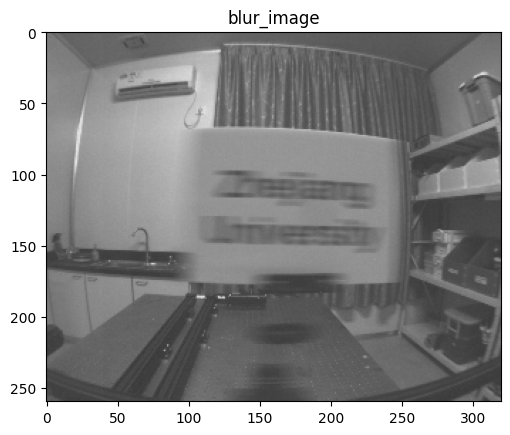

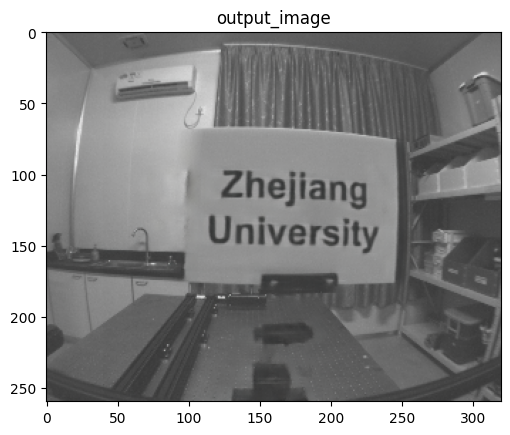

In [15]:
if __name__ == '__main__':
    model = EFNet().cuda()
    ## transform
    transform_to_tensor = transforms.ToTensor()
    ## load checkpoint
    checkpoint_dir = './TA_session/EFNet/ckpts/net_g_latest_REBlur.pth'
    ckpt = torch.load(checkpoint_dir)
    model.load_state_dict(ckpt['params'])
    print('success fully load the EFNet!')
    ## read sample data
    sample_dir = './TA_session/EFNet/samples/'
    blur_image_name = os.path.join(sample_dir, "blur_img.png")
    mask_name = os.path.join(sample_dir, "mask.png")
    event_voxel_name = os.path.join(sample_dir, "event_voxel.npy")
    ## blur image
    blur_img_np = Image.open(blur_image_name)
    blur_img = transform_to_tensor(blur_img_np).cuda()[None, ...]
    ## mask
    mask = transform_to_tensor(Image.open(mask_name)).cuda()[None, ...]
    ## event voxel
    event_voxel = torch.from_numpy(np.load(event_voxel_name)).cuda()[None, ...]
    print(event_voxel.shape)
    print(blur_img.shape)
    print(mask.shape)
    ## excute and visualize
    output = model(blur_img, event_voxel, mask)
    output_for_viz = 255*output[0].detach().cpu().numpy().squeeze().transpose(1,2,0)
    output_for_viz = output_for_viz.astype(np.uint8)
    print(output_for_viz.max())
    plt.figure()
    plt.title('blur_image')
    plt.imshow(Image.open(blur_image_name))
    plt.figure()
    plt.title('output_image')
    plt.imshow(output_for_viz)